In [1]:
# Import necessary modules
import pandas as pd
import matplotlib as plt
from matplotlib.pyplot import figure
import numpy as np

In [2]:
strt2 = pd.read_csv('./data/filtedstreets.csv', sep= ",")
bikecl = pd.read_csv('./data/bikecollisiondata_with_nearest_street_index2_updated.csv', sep= ",")

In [3]:
bikecl.columns

Index(['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE',
       'INTKEY', 'LOCATION', 'EXCEPTRSNC', 'EXCEPTRSND', 'SEVERITYCO',
       'SEVERITYDE', 'COLLISIONT', 'PERSONCOUN', 'PEDCOUNT', 'PEDCYLCOUN',
       'VEHCOUNT', 'INJURIES', 'SERIOUSINJ', 'FATALITIES', 'INCDATE',
       'INCDTTM', 'JUNCTIONTY', 'SDOT_COLCO', 'SDOT_COLDE', 'INATTENTIO',
       'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTG',
       'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY',
       'CROSSWALKK', 'HITPARKEDC', 'geometry', 'near_str_index', 'min_length',
       'weather_group', 'date', 'time', 'hour', 'dayofweek', 'weekday',
       'rushhour', 'weather_group2'],
      dtype='object')

In [4]:
strt2['index'] = strt2.index

In [5]:
n = 2 * len(strt2)

In [6]:
temp = (np.zeros(int(n*0.73))).tolist() + (np.ones(n- int(n*0.73))).tolist()

In [7]:
simulate_street = pd.concat([strt2]*2, ignore_index=True)  

In [8]:
simulate_street['simulate_rushhour'] = temp

In [9]:
len(bikecl)

5707

In [10]:
temp = bikecl.groupby(['near_str_index']).size().reset_index()

In [11]:
temp.columns

Index(['near_str_index', 0], dtype='object')

In [12]:
max(temp.iloc[:,1])

32

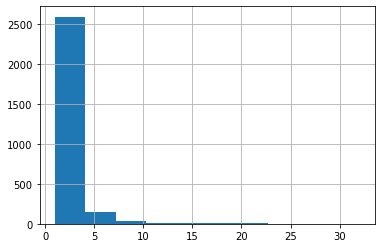

In [13]:
temp.iloc[:,1].hist()

In [15]:
full = pd.merge(simulate_street, bikecl, left_on= ['index','simulate_rushhour'],
                right_on = ['near_str_index','rushhour'], how ='left', indicator = True)

In [23]:
full['acc'] = [ 1 if i == 'both' else 0 for i in full['_merge']]

In [24]:
numeric_features = ['SPEEDLIMIT','SEGLENGTH','SURFACEWID', 'PVMTCONDIN', 'PVMTCOND_1','SLOPE_PCT' ]
categorical_features = ['ARTCLASS', 'SEGDIR', 'ONEWAY', 'SURFACETYP','NATIONHWYS' ,'PVMTCATEGO', 'PARKBOULEV' ,'TRANDESCRI', 'rushhour']
X = full[numeric_features + categorical_features ].copy()
y = full['acc']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.1)

In [27]:
# initial parameters
RANDOM_STATE = 42
#RATIO = 0.1
K_FOLD = 5

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


## pre-processing 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [29]:
## pre-processing 

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [30]:
# imbalanced learn 
rus = RandomUnderSampler(random_state=RANDOM_STATE) #ratio = RATIO

In [31]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(solver='liblinear')

In [32]:
## Logsitic Regression
from imblearn.pipeline import make_pipeline

logReg = make_pipeline(preprocessor,rus, log)
#logReg = Pipeline(steps=[('preprocessor', preprocessor),('undersampler', rus),('classifier', log)])

In [35]:
## cross validate 
from sklearn.model_selection import cross_validate

scores = cross_validate(logReg, X_train, y_train, scoring=['roc_auc','recall','accuracy'], cv = K_FOLD, return_train_score= True, return_estimator=True)

In [36]:
scores

{'fit_time': array([3.23406792, 4.25736785, 4.411376  , 2.61911917, 3.97580886]),
 'score_time': array([0.1628921 , 0.16118026, 0.14926791, 0.15219903, 0.14472032]),
 'estimator': (Pipeline(memory=None,
           steps=[('columntransformer',
                   ColumnTransformer(n_jobs=None, remainder='drop',
                                     sparse_threshold=0.3,
                                     transformer_weights=None,
                                     transformers=[('num',
                                                    Pipeline(memory=None,
                                                             steps=[('imputer',
                                                                     SimpleImputer(add_indicator=False,
                                                                                   copy=True,
                                                                                   fill_value=None,
                                                        